# Extended Kalman Filter design for bicycle's multibody dynamics simulation

In [1]:
# Import dependencies
from __future__ import division, print_function
%matplotlib inline

import scipy
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints

from BicycleTrajectory2D import *
from BicycleUtils import *
from FormatUtils import *
from PlotUtils import *
from UKF_RST import UnscentedKalmanFilter as UKF

from DatasetHelper import *
from DatasetImporter import *

## Load dataset

In [2]:
global_path = '../../bags/simulations/csv/'
#file_name = 'velocity_5/velocity_5_preprocessed.csv'
#file_name = 'velocity_7/velocity_7_preprocessed.csv'
file_name = 'velocity_8/velocity_8_preprocessed.csv'
#file_name = 'velocity_10/velocity_10_preprocessed.csv'

# Read dataset
data = pd.read_csv(global_path + file_name, index_col=0, parse_dates=True)
data['time_index'] = pd.to_datetime(data['time'])
data = data.set_index('time_index', drop=True, verify_integrity=True)
data['time'] = data.index
di = SimulationDatasetHelper(data)

# degree to radians conversion
di.data[di.gt_phi] = di.data[[di.gt_phi]]*np.pi/180.0
di.data[di.sim_phi] = di.data[[di.sim_phi]]*np.pi/180.0

di.data[di.gt_delta] = -di.data[[di.gt_delta]]*np.pi/180.0 
di.data[di.sim_delta] = -di.data[[di.sim_delta]]*np.pi/180.0

di.data[di.gt_psi] = di.data[[di.gt_psi]]*np.pi/180.0 + np.pi/2
di.data[di.sim_psi] = di.data[[di.sim_psi]]*np.pi/180.0 + np.pi/2

# select time: convert from pandas to numpy and fix initial offset
time = di.data[di.time].as_matrix()
time = time.astype('float64')/1e9
time = time - time[0]

# select state vector as reference (gt):
gt = di.data.filter(items=[di.gt_x, di.gt_y, di.gt_z, di.gt_delta, di.gt_psi, di.gt_phi]).as_matrix()

# select simulated measurements Z (sim):
sim = di.data.filter(items=[di.sim_xf, di.sim_xr, di.sim_yf, di.sim_yr,
                            di.sim_zf, di.sim_zr, di.sim_za,
                            di.sim_delta, di.sim_psi, di.sim_phi]).as_matrix()

# select inputs:
U = di.data.filter(items=[di.gt_v, di.angular_vel_delta, di.angular_vel_phi]).as_matrix()

## Implementation of UKF for $\sigma$-model

### Define state vector:

$$ X = 
\begin{bmatrix}x & y & z & v & \sigma & \psi & \phi \end{bmatrix}^\mathsf T$$

### Define measurement vector:

$$ Z = 
\begin{bmatrix}x_f & x_r & y_f & y_r & z_f & z_r & z_a & \sigma & \psi & \phi \end{bmatrix}^\mathsf T$$

In [3]:
class UKF_Sigma_model_sensor_fusion(object):
    def __init__(self, Q, R, sigma, dt=0.25, w=1.0):
        self.fx_filter_vel = 0.0
        self.fy_filter_vel = 0.0
        self.fz_filter_vel = 0.0
        self.fsigma_filter_vel = 0.0
        self.fpsi_filter_vel = 0.0
        self.fphi_filter_vel = 0.0
        self.U_init = []
                
        self.w = w
        self.dt = dt
        self.t = 0
        self.number_state_variables = 6
                         
        [self.alpha, self.beta, self.kappa] = [sigma[0], sigma[1], sigma[2]]
        
        self.points = MerweScaledSigmaPoints(n=self.number_state_variables, 
                                             alpha=self.alpha, beta=self.beta, kappa=self.kappa)

        self.kf = UKF(dim_x=number_state_variables, dim_z=10, dt=self.dt, 
                 fx=self.f_bicycle, hx=self.H_bicycle, points=self.points)
        
        # Q Process Noise Matrix
        self.kf.Q = Q 
       
        # R Measurement Noise Matrix
        self.kf.R = R

        self.kf.x = np.zeros((1, self.number_state_variables))    # Initial state
        self.kf.P = np.eye(self.number_state_variables) * 10     # Covariance matrix 

    def fx_filter(self, x, t):
        return self.fx_filter_vel

    def fy_filter(self, y, t):
        return self.fy_filter_vel
    
    def fz_filter(self, y, t):
        return self.fz_filter_vel
    
    def fsigma_filter(self, y, t):
        return self.fsigma_filter_vel

    def fpsi_filter(self, yaw, t):
        return self.fpsi_filter_vel
    
    def fphi_filter(self, yaw, t):
        return self.fphi_filter_vel
    
    def rk4(self, y, x, dx, f):
        k1 = dx * f(y, x)
        k2 = dx * f(y + 0.5*k1, x + 0.5*dx)
        k3 = dx * f(y + 0.5*k2, x + 0.5*dx)
        k4 = dx * f(y + k3, x + dx)

        return y + (k1 + 2*k2 + 2*k3 + k4) / 6.

    def f_bicycle(self, x, dt, U=None):  
        if U is None:
            U = self.U_init
            
        self.dt = dt
            
        x_out = x
        [x_ini, y_ini, z_ini, sigma_ini, psi_ini, phi_ini] = x
        
        v_ini = U[0]
        phi_dot = U[1]
        delta_dot = U[2]

        #Solve diff equation by approximation
        x = self.rk4(x_ini, self.t, self.dt, self.fx_filter)
        y = self.rk4(y_ini, self.t, self.dt, self.fy_filter)
        z = self.rk4(z_ini, self.t, self.dt, self.fz_filter)
        sigma = self.rk4(sigma_ini, self.t, self.dt, self.fsigma_filter)
        psi = self.rk4(psi_ini, self.t, self.dt, self.fpsi_filter)
        phi = self.rk4(phi_ini, self.t, self.dt, self.fphi_filter)

        self.fx_filter_vel = math.cos(psi) * v_ini
        self.fy_filter_vel = math.sin(psi) * v_ini
        self.fz_filter_vel = 0
        self.fsigma_filter_vel = (phi_dot / self.w)*(1 + (self.w**2)*(sigma_ini**2))
        self.fpsi_filter_vel = (v_ini * sigma_ini) / math.cos(phi_ini)
        self.fphi_filter_vel = phi_dot

        x_out[0] = x
        x_out[1] = y
        x_out[2] = z
        x_out[3] = sigma
        x_out[4] = psi
        x_out[5] = phi

        return x_out

    def H_bicycle(self, x):
        """ takes a state variable and returns the measurement
        that would correspond to that state. """        
        sensor_out = np.zeros(10)
        sensor_out[0] = x[0]
        sensor_out[1] = x[0]
        sensor_out[2] = x[1]
        sensor_out[3] = x[1]
        sensor_out[4] = x[2]
        sensor_out[5] = x[2]
        sensor_out[6] = x[2]
        sensor_out[7] = x[3] # sigma
        sensor_out[8] = x[4] # psi
        sensor_out[9] = x[5] # phi
        
        return sensor_out

Execute filter

In [4]:
[t, wheel_distance, number_state_variables] = [0.0, 1.1, 6]

X_init = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])  # [x, y, z, sigma, psi, phi]

zs_gt = di.data[[di.gt_x, di.gt_y, di.gt_z, di.gt_delta, di.gt_psi, di.gt_phi]].as_matrix()
zs_sim = di.data[[di.sim_xf, di.sim_xr, di.sim_yf, di.sim_yr, 
                  di.sim_zf, di.sim_zr, di.sim_za,
                  di.sim_delta, di.sim_psi, di.sim_phi]].as_matrix()
u_sim = di.data[[di.sim_v, di.angular_vel_phi, di.angular_vel_delta]].as_matrix()
time_t = di.data[[di.time]].as_matrix()

dt = 1.0/1000.0 # Slower Sample Rate of the Measurements is 5Hz

# Q Process Noise Matrix
Q = np.diag([(0.1)**2, (0.1)**2, (0.1)**2, (0.1)**2, (0.1)**2, (0.1)**2])  # [x, y, z, sigma, psi, phi]

# measurement noise covariance R [xf, xr, yf, yr, zf, zr, za, delta, psi, phi]
# R_std = [8.5**2, 8.5**2, 8.5**2, 1.8**2, 8.5**2, 1.8**2] # [x, y, z, sigma, psi, phi]
R_std = [20.5**2, 20.5**2,  # x
         20.5**2, 20.5**2,  # y
         10.5**2, 10.5**2, 7.5**2,  # z
         0.5**2, 0.5**2, 0.5**2] # delta - psi - phi

# R Measurement Noise Matrix
R = np.diag(R_std)

''' Sigma point'''
sigma = [alpha, beta, kappa] = [0.7, 2.0, -2.0]

filter_ukf = UKF_Sigma_model_sensor_fusion(Q=Q, R=R, sigma=sigma, dt=dt, w=wheel_distance)

Z  = np.zeros((1, 10))
xs = np.zeros((len(time_t), number_state_variables))
PU = np.zeros((len(time_t), number_state_variables))
KU = np.zeros((len(time_t), number_state_variables))

mus = np.zeros((len(time_t), number_state_variables))
us = np.zeros((len(time_t), 3))  # 3 inputs
dts = np.zeros((len(time_t), 1))  # real dt
ps = np.zeros((len(time_t), number_state_variables, number_state_variables))
qs = np.zeros((len(time_t), number_state_variables, number_state_variables))

dt_real = dt

for i in range(len(time_t)):
    if i > 0:
        dt_real = float(time_t[i] - time_t[i-1])/1e9 # time: nano to seg
        
    P = filter_ukf.kf.P
    K = filter_ukf.kf.K
    PU[i] = [P[0,0], P[1,1], P[2,2], P[3,3], P[4,4], P[5,5]]
    KU[i] = [K[0,0], K[1,1], K[2,2], K[3,3], K[4,4], K[5,5]]

    xs[i,:] = filter_ukf.kf.x
    mus[i] = filter_ukf.kf.x
    ps[i] = filter_ukf.kf.P
    qs[i] = filter_ukf.kf.Q
    us[i] = u_sim[i]
    dts[i] = dt_real
    
    filter_ukf.kf.predict(dt=dt_real, fx_args=(u_sim[i]))
    
    #Update measurements [xf, xr, yf, yr, zf, zr, za, delta, psi, phi]
    filter_ukf.kf.update(zs_sim[i])

xs[:, 3] = np.arctan2(xs[:, 3], 1/wheel_distance)  # sigma to delta conversion

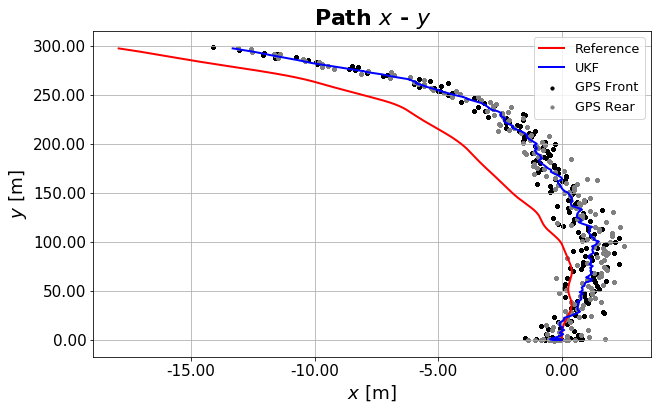

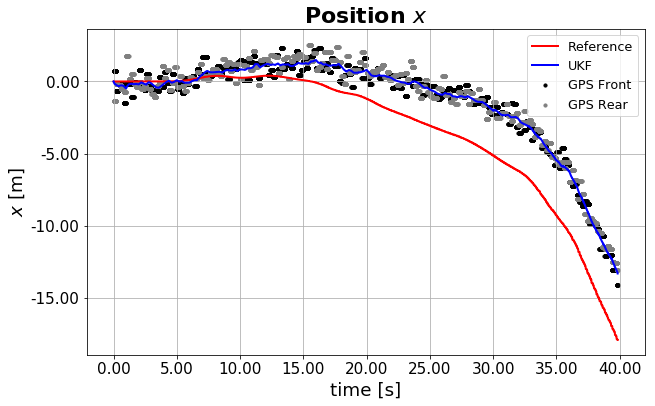

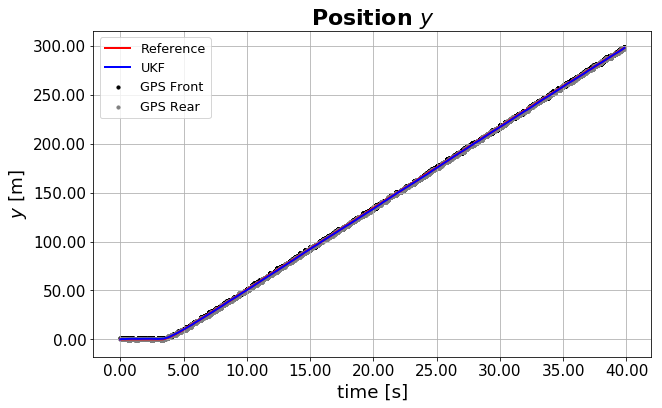

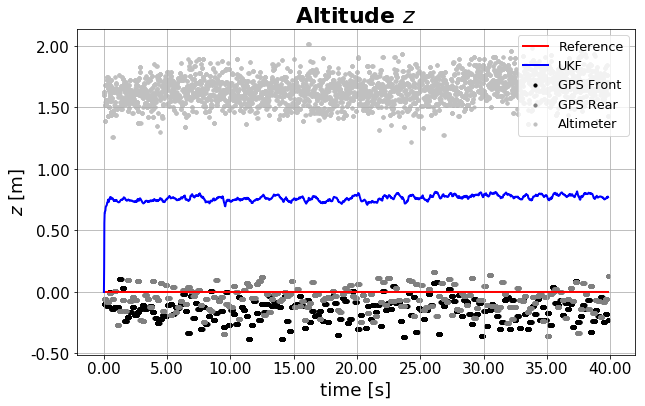

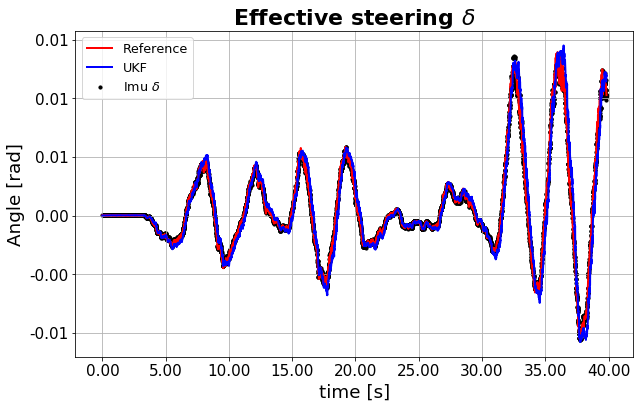

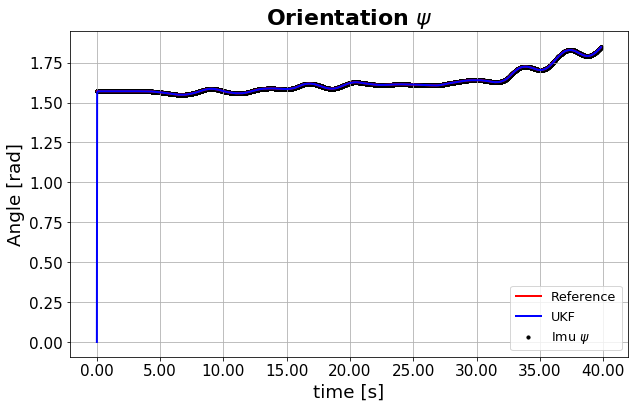

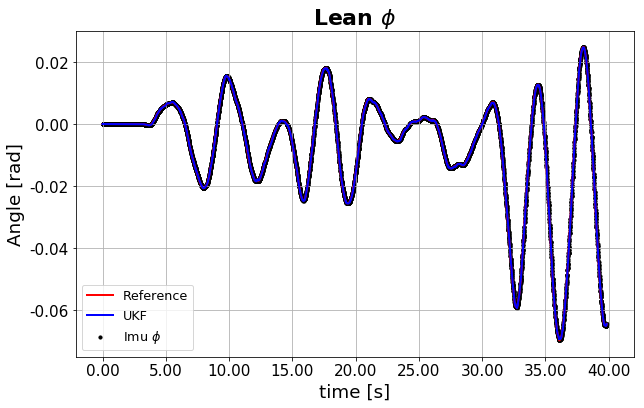

In [5]:
filter_name = 'UKF'
path_output_filter = 'filters/UKF/multibody_sim/' + file_name.split("/")[0] + "/"
plot_filter_results(xs, zs_gt, zs_sim, time, path_output_filter, filter_name, autoscale_axis=True)

### Kalman gain and process covariance

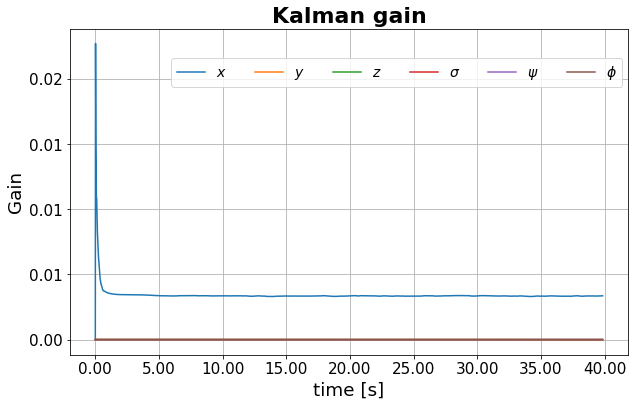

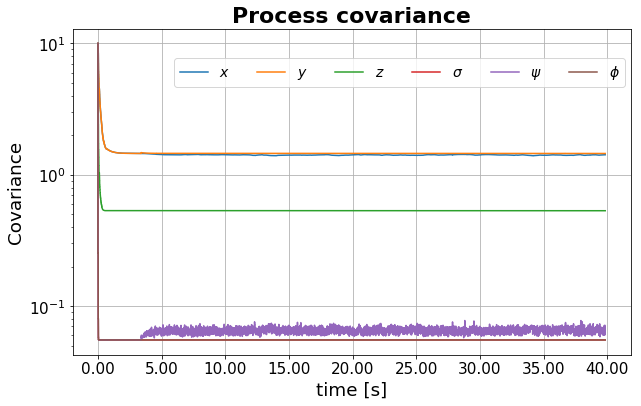

In [6]:
plot_EKF_gain_covariance(time, KU, PU, path_output_filter, autoscale_axis=True)

### RTS Smoother

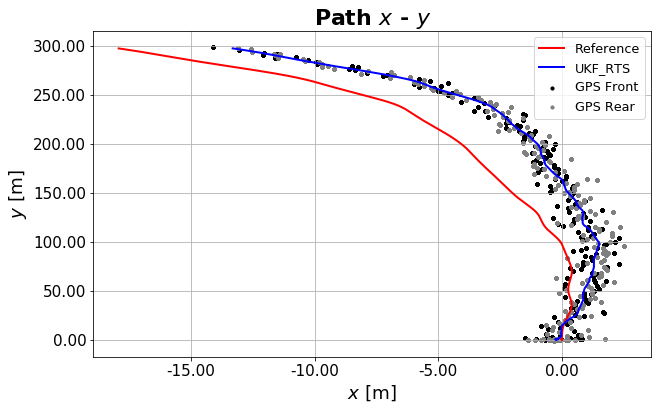

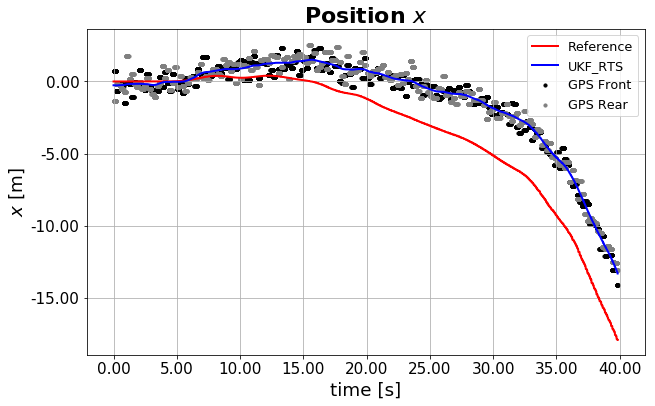

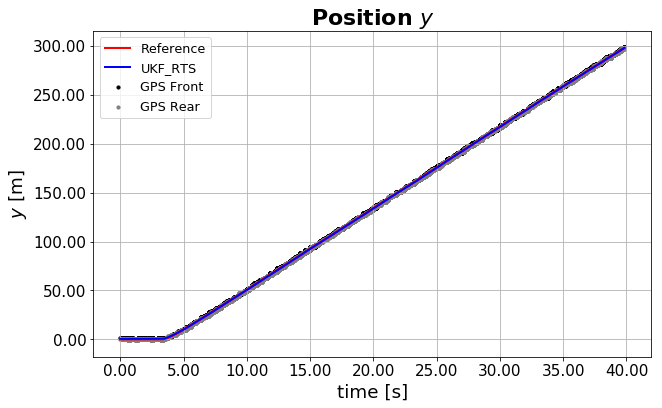

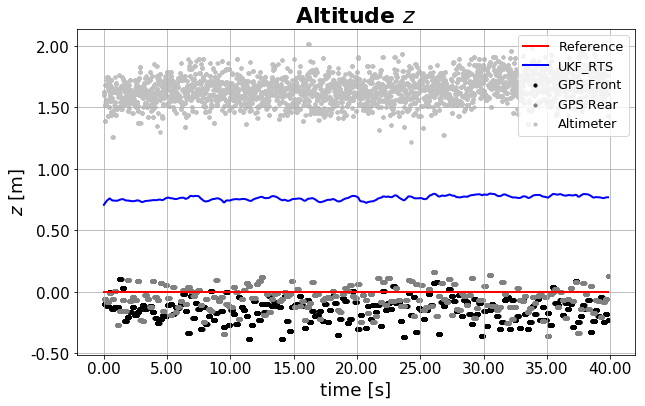

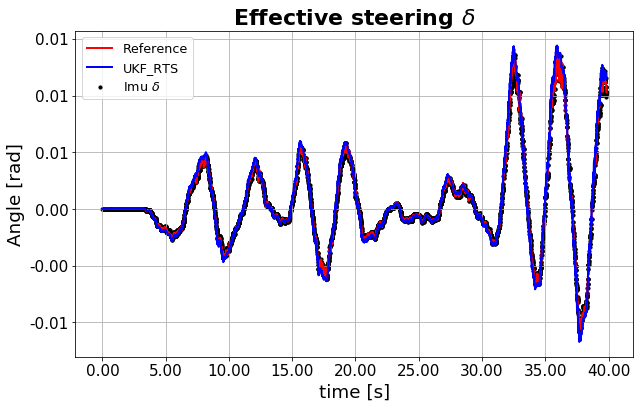

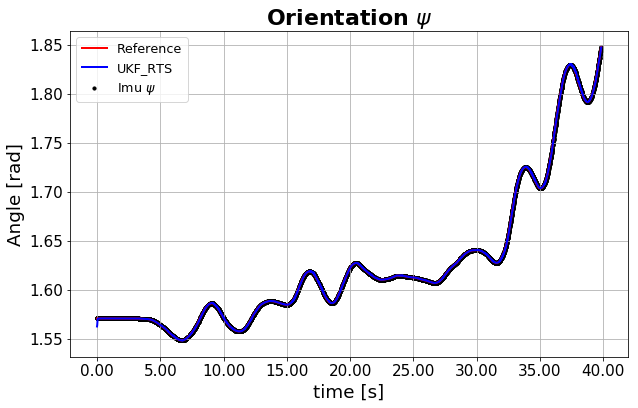

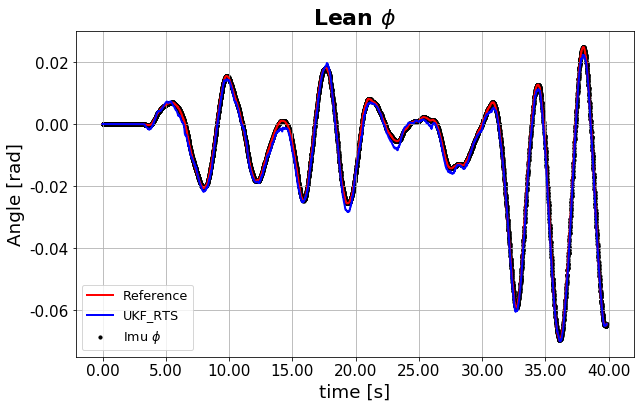

In [7]:
(x, P, K) = filter_ukf.kf.rts_smoother(Xs=mus, Ps=ps, Qs=qs, dt=dts, U=us)
x[:, 3] = np.arctan2(x[:, 3], 1/wheel_distance)  # sigma to delta conversion

filter_name = 'UKF_RTS'
rts_file_name = path_output_filter + 'RTS_'
plot_filter_results(x, zs_gt, zs_sim, time, rts_file_name, filter_name, autoscale_axis=True)